# Code to look at predictions

In [1]:
import numpy as np
import torch
import matplotlib
import seaborn as sns; sns.set()
from matplotlib import colors
from matplotlib import pyplot as plt
device = "cpu"
%matplotlib notebook

# Define nonlinear activation function
def f(x): # nonlinear conversion function to binary
    return x.sigmoid()#tanh().add(1).div(2)

In [2]:
# lists of parameters
#Rs = [0.0, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]
Rs = [0.0, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]
Ns = [50, 100, 200, 300]

## Load NN and make predictions

In [3]:
N_ind = 0
N = Ns[N_ind]

errs_all_R = []
y_bin=[]

for R in Rs[1:]:

    x = torch.tensor(np.genfromtxt("x_{}.csv".format(N), delimiter=','), device=device).float()
    y = torch.tensor(np.genfromtxt("y_{}.csv".format(N), delimiter=','), device=device).float()
#_22july
    w1 = torch.tensor(np.loadtxt("Data_22july/weights1_{}_{}.dat".format(N, R)), dtype=torch.float32, device=device)
    w2 = torch.tensor(np.loadtxt("Data_22july/weights2_{}_{}.dat".format(N, R)), dtype=torch.float32, device=device)
    b1 = torch.tensor(np.loadtxt("Data_22july/bias1_{}_{}.dat".format(N, R)), dtype=torch.float32, device=device)
    b2 = torch.tensor(np.loadtxt("Data_22july/bias2_{}_{}.dat".format(N, R)), dtype=torch.float32, device=device)

    y_pred = f(f(x.mm(w1).add(b1)).mm(w2).add(b2))
    y_pred = y_pred.detach().numpy()
    y_org = y.detach().numpy()
    y_bin.append(np.round(y_pred))
    

## Visualize data as a grid

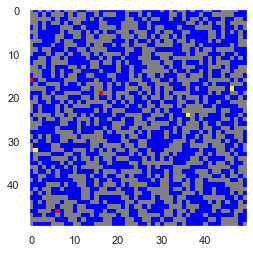

In [20]:
# specify Rs id to plot
id_to_check=8

# code to plot a colored grid highlighting errors:
data = 2*y_org+y_bin[id_to_check]
# create discrete colormap
cmap = colors.ListedColormap(['grey', 'yellow', "red", "blue"]) 
# white  - 0 predicted correctly
# yellow - 1 predicted instead of 0
# red    - 0 predicted instead of 1
# blue   - 1 predicted correctly

bounds = [0, 0.5, 1, 1.5, 2, 2.5, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
ax.imshow(data, cmap=cmap, norm=norm)
ax.grid(False) # no gridlines
plt.show()

# save ind for the errors of a null model
r_ids_n, c_ids_n = np.where((data == 1)|(data==2))

# save fugure
#fig.savefig("graphs/pred_50x50x50_Rs_{}.pdf".format(Rs[id_to_check+1]))
#sns.clustermap(data, cmap=cmap) # another way to do it?

## Modify NN to model conditional behavior

In [16]:
# specify hidden layer neuron to activate
id_activate=8

# add another column of 111...111 to the tensor of inputs
x_new=torch.cat((x,torch.ones(N,1)), dim=1)

# add another row of weights for this new input neuron
add=torch.zeros(1, w1.size()[1])
add[:,id_activate]=1000000
w1_new=torch.cat((w1,add), dim=0)

# calculate new binary predictions
y_pred_new = f(f(x_new.mm(w1_new).add(b1)).mm(w2).add(b2))
y_pred_new = y_pred_new.detach().numpy()
binary_y_new = np.round(y_pred_new)

## Plot predicted behavior over the actual one 

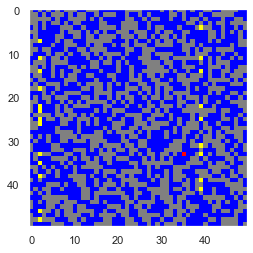

In [31]:
# plot a colored grid highlighting "errors" (comparing to the model predictions) for a conditional behavior data:
data = 2*y_bin[id_to_check]+binary_y_new
cmap = colors.ListedColormap(['grey', 'yellow', "red", "blue"])
bounds = [0, 0.5, 1, 1.5, 2, 2.5, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
ax.imshow(data, cmap=cmap, norm=norm)
ax.grid(False) # no gridlines
#plt.show()

# save plot
#fig.savefig("graphs/CD_50x50x50_hn_{}.pdf".format(id_activate))

## The same results if we change biases instead of weights

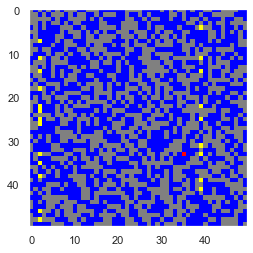

In [32]:
# shift bias to control the activation threshold
b1_new=b1.clone()
b1_new[id_activate]=1000000

y_pred_new = f(f(x.mm(w1).add(b1_new)).mm(w2).add(b2))
y_pred_new = y_pred_new.detach().numpy()
binary_y_new = np.round(y_pred_new)

# plot a colored grid highlighting "errors" for a conditional behavior data:
data = 2*y_bin[id_to_check]+binary_y_new
cmap = colors.ListedColormap(['grey', 'yellow', "red", "blue"])
bounds = [0, 0.5, 1, 1.5, 2, 2.5, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
ax.imshow(data, cmap=cmap, norm=norm)
ax.grid(False) # no gridlines

## Plots and statistics for all hidden units perturbed

In [54]:
# plot the above for all hidden activated neurons and calc some statistics
diss=[]
r_idss=[]
c_idss=[]
beh_aff=np.zeros(N)
mu_aff=np.zeros(N)

for id_activate in range(N):
    # specify hidden layer neuron to activate
    b1_new=b1.clone()
    b1_new[id_activate]=1000000

    y_pred_new = f(f(x.mm(w1).add(b1_new)).mm(w2).add(b2))
    y_pred_new = y_pred_new.detach().numpy()
    binary_y_new = np.round(y_pred_new)

    # uncomment to plot
    '''
    # plot a colored grid highlighting "errors" for a conditional behavior data:
    data = 2*y_bin[id_to_check]+binary_y_new
    cmap = colors.ListedColormap(['grey', 'yellow', "red", "blue"])
    bounds = [0, 0.5, 1, 1.5, 2, 2.5, 3]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(data, cmap=cmap, norm=norm)
    ax.grid(False) # no gridlines

    #fig.savefig("graphs/CD_50x50x50_hn_{}.pdf".format(id_activate))
    '''
    # save discrepancy matrix
    dis = y_bin[id_to_check]-binary_y_new
    diss.append(dis)
    
    r_ids, c_ids = np.where((dis == 1)|(dis==-1))
    r_idss.append(r_ids) # save indices of affected motor units for each behavior
    c_idss.append(c_ids)
    beh_aff[id_activate]=np.unique(r_ids).size # check how many behaviors were affected
    mu_aff[id_activate]=np.unique(c_ids).size  # check how many motor units were affected

## Code for analysis of perturbations in hidden layer activation 

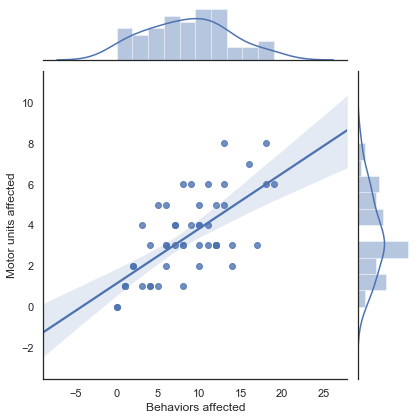

In [72]:
# plot how many behaviors and motor units were affected by each hidden neuron

import pandas as pd
sns.set(style="white", color_codes=True)
df = pd.DataFrame(np.transpose(np.array([beh_aff,mu_aff])), columns=["Behaviors affected", "Motor units affected"])
sns.jointplot(x="Behaviors affected", y="Motor units affected", data=df, kind="reg", 
              marginal_kws=dict(bins=10));

In [103]:
# calc all unique behaviors in list of affected ones - each one was affected at least once

# function to get unique values from a list
def unique(list1): 
    # intilize a null list 
    unique_list = []  
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        ux=np.unique(x)
        for j in range(ux.size):
            if ux[j] not in unique_list: 
                unique_list.append(ux[j])
    # print list 
    unique_list=np.sort(unique_list)
    return(unique_list)
        
u=unique(r_idss)
u.size

50

[ 7. 14.  5. 13. 17. 15.  8. 12. 10. 12.  8.  7. 16.  6.  9. 15.  8. 17.
 10. 18. 11. 10. 15. 11. 14. 22. 17. 13.  7. 16. 16. 15. 23. 16. 15. 15.
 19. 14. 15. 14. 11. 14. 20. 19. 10. 12. 12. 12. 19. 16.]


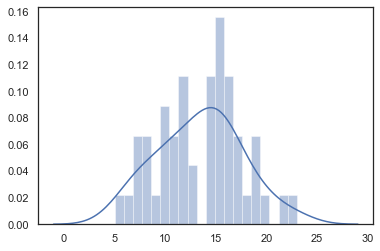

In [108]:
# calc counts for unique behaviors affected

# function to get unique values from a list
def list_table(list1, N): 
    # intilize a null vector
    counts = np.zeros(N)
    # traverse for all elements 
    for x in list1: 
        for j in range(x.size):
            counts[x[j]]+=1 
    return(counts)
print(list_table(r_idss, N))
sns.distplot(list_table(r_idss, N), bins=20)

[31.  7. 23. 23.  8. 17. 18. 19. 10. 16.  6.  7. 26.  3. 15.  8. 10.  8.
 18. 14.  8. 25. 14.  7. 15. 15.  6. 11. 16.  7.  4. 14. 10. 11. 12. 21.
 12. 20.  6. 24. 16. 18. 15.  6.  2. 12. 10.  8. 22. 16.]


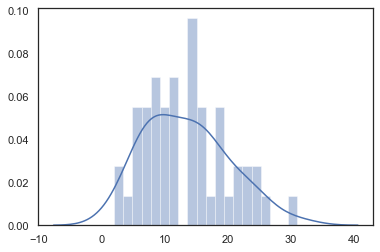

In [110]:
# check whether the same groupds of neurons were affected in diff beh
print(list_table(c_idss, N))
sns.distplot(list_table(c_idss, N), bins=20)